# Dice Game

In [1]:
# Some useful libraries
import numpy as np
import matplotlib.pyplot as plt

## Task 1

The state space is
$$\mathcal{S} = \{ 0, 1, 2, 3, \ldots, 31\},$$
where the only terminal state is $31$.
The initial state of the game is $0$.

The action space is
$$\mathcal{A} = \{\text{``roll 1''}, \text{``roll 2''}, \text{``bet 1''}, \text{``bet 2''}, \text{``bet 3''}\}.$$
Every action is available in every state.


The reward set can be conveniently split into the possible rewards per action

- $\mathcal{R}_{r1} = \{-11, -1\}$
- $\mathcal{R}_{r2} = \{-12, -2, 8\}$
- $\mathcal{R}_{b1} = \{-30, -29, \ldots, 5\}$
- $\mathcal{R}_{b2} = \{-60, -58, \ldots, 10\}$
- $\mathcal{R}_{b3} = \{-90, -87, \ldots, 15\}$

yielding the complete reward set
$$
\mathcal{R}
= \mathcal{R}_{r1} \cup \mathcal{R}_{r2}
\cup \mathcal{R}_{b1} \cup \mathcal{R}_{b2} \cup \mathcal{R}_{b3}
.
$$


## Task 2

The reinforcement task is implemented as a python class called `DiceGame` in the file `diceClass.py`, we only need to import it here.

In [2]:
from diceGame import ACTIONS, ACTION_BET_1, ACTION_BET_2, ACTION_BET_3, ACTION_ROLL_1, ACTION_ROLL_2, ACTION_NAMES
from diceGame import DiceGame

Using the `.step()` method we can perform some test actions.

In [3]:
dg = DiceGame(verbose=True)
print(dg.step(ACTION_ROLL_2))
print(dg.step(ACTION_ROLL_1))
print(dg.step(ACTION_BET_2))

Action: rollTwo
Dice: 4
Dice 2: 5
Reward: -2 --- State: 9
(-2, 9)
Action: roll
Dice: 6
Reward: -1 --- State: 15
(-1, 15)
Action: betTwo
Dealer eyes 30
Reward: -30 --- State: 31
(-30, 31)


Using the `.play()` method we can play interactively (*note: not required for this task*).

In [4]:
dg = DiceGame()
# dg.play() # Uncomment to play

## Task 3

Policy evaluation is implemented as a function in `helpers.py` which we import here.

In [5]:
from helpers import evaluatePolicy

Next, we define the policies.
To use non-deterministic policies, we represent a policy of a list of lists, representing the probabilities of each action in each state, i.e.
```
somePolicy[state] = [P_ROLL1, P_ROLL2, P_BET1, P_BET2, P_BET3]
```

We use the class attributes of the `DiceGame` class to access constants like the "bust" value or the set of states, but do not call any methods (or even create an instance of it).
These constants could also be stored in regular global variables.

In [6]:
# Helper functions to create a policy(-entry)
def makeActionProbs(roll1 = 0, roll2 = 0, bet1 = 0, bet2 = 0, bet3 = 0, all = 0):
    probs = [roll1, roll2, bet1, bet2, bet3]
    probs = [p + all for p in probs]
    probs = [p / sum(probs) for p in probs]
    return probs

In [7]:
policyRoll1 = [makeActionProbs(roll1 = 1) for s in DiceGame.STATES]
policyRoll2 = [makeActionProbs(roll2 = 1) for s in DiceGame.STATES]
policyRandom = []
for s in DiceGame.STATES:
    if s < 20:
        policyRandom.append(makeActionProbs(roll1 = 1, roll2 = 1))
    else:
        policyRandom.append(makeActionProbs(bet1 = 1, bet2 = 1, bet3 = 1))

Below we perform policy evaluation.
See `helpers.py` for the actual code.

In [8]:
valuesRoll1 = evaluatePolicy(policyRoll1)
valuesRoll2 = evaluatePolicy(policyRoll2)
valuesRandom = evaluatePolicy(policyRandom)

Below is a plot illustrating the value functions.

In [9]:
POLICY_NAME_ROLL1 = 'R1'
POLICY_NAME_ROLL2 = 'R2'
POLICY_NAME_RANDOM = 'RR'
POLICY_NAME_OPTIMAL = 'Optimal'

In [10]:
PLOT_IND1 = DiceGame.TERMINAL
x = DiceGame.STATES[:PLOT_IND1]

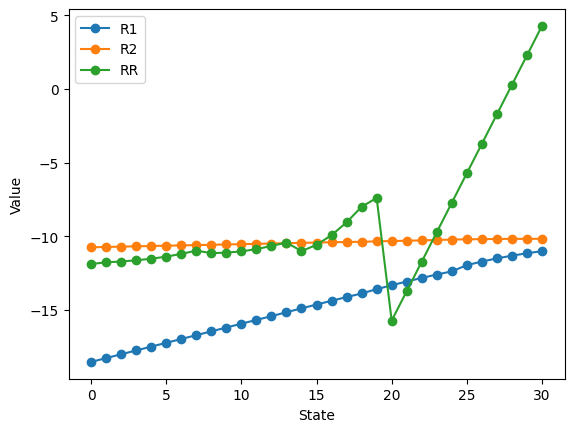

In [11]:
plt.figure()
plt.plot(x, valuesRoll1[:PLOT_IND1], 'o-', label=POLICY_NAME_ROLL1)
plt.plot(x, valuesRoll2[:PLOT_IND1], 'o-', label=POLICY_NAME_ROLL2)
plt.plot(x, valuesRandom[:PLOT_IND1], 'o-', label=POLICY_NAME_RANDOM)
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()
plt.show()

Some observations:
* Value of "Roll 1" increases with state, since we are closer to finishing the game
* Value of "Roll 2" decreases slightly with state, since we have fewer chances to roll a double
* Value of "RR" has a distinct jump when we go from rolling to betting

## Task 4

Below we implement policy iteration to find an optimal policy.
First, we import the helper functions `chooseGreedyPolicy` and `evaluatePolicy`, which are used in policy iteration,
and `randomToDeterministicPolicy`, which helps in plotting a deterministic policy.

In [12]:
from helpers import chooseGreedyPolicy, evaluatePolicy, randomToDeterministicPolicy

In [13]:
# Start with a uniformly random policy
optimalPolicy = [makeActionProbs(all=1) for s in DiceGame.STATES]

# Perform policy iteration, following the code from class/seminars/Sutton&Barto
while True:
    valuesOptimal = evaluatePolicy(optimalPolicy)
    newPolicy = chooseGreedyPolicy(valuesOptimal)
    
    if optimalPolicy == newPolicy:
        break
    
    optimalPolicy = newPolicy

Below is an illustration of the optimal policy.

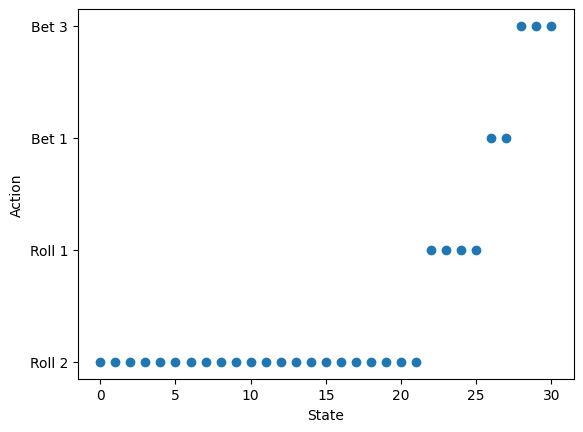

In [14]:
detPolicy = randomToDeterministicPolicy(optimalPolicy)
stringPolicy = [ACTION_NAMES[a] for a in detPolicy]

plt.figure()
plt.scatter(x, stringPolicy[:PLOT_IND1])
plt.xlabel('State')
plt.ylabel('Action')
plt.show()


Combining the value and policy plot might be interesting.

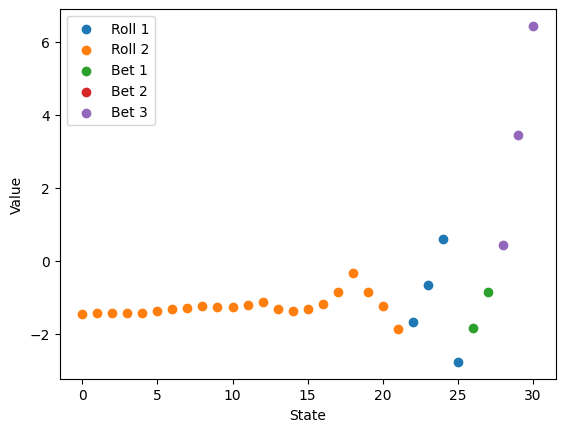

In [15]:
actionIndices = range(len(ACTIONS))

plt.figure()

for action, actionName in zip(actionIndices, ACTION_NAMES):
    x = [s for s in range(DiceGame.TERMINAL) if detPolicy[s] == action]
    y = [valuesOptimal[s] for s in x]
    plt.scatter(x, y, label=actionName)
plt.legend()
plt.xlabel('State')
plt.ylabel('Value')
plt.show()


Lastly, we compute and plot the action-value function for the optimal policy.

In [16]:
from helpers import evaluateAction

actionValueFunction = []
for state in DiceGame.STATES:
    actionValues = [evaluateAction(state, valuesOptimal, action) for action in ACTIONS]
    actionValueFunction.append(actionValues)


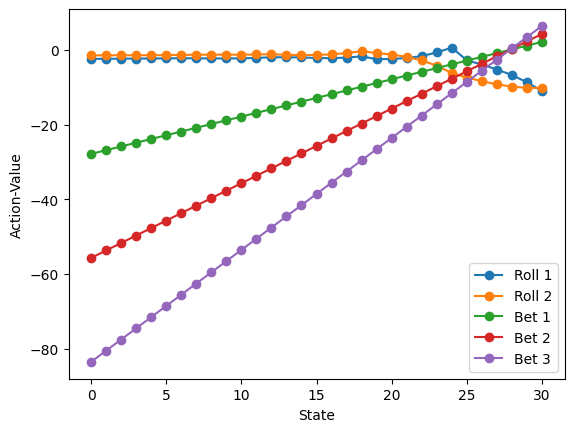

In [17]:
plt.plot(actionValueFunction[:PLOT_IND1], 'o-')
plt.legend(labels = ACTION_NAMES)
plt.xlabel('State')
plt.ylabel('Action-Value')
plt.show()

Below we compare the optimal policy to the ones considered above.

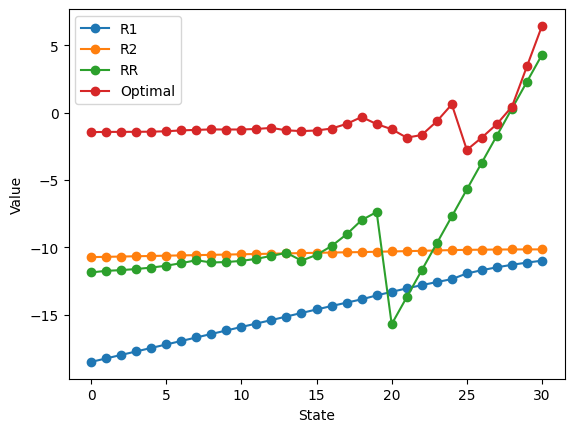

In [18]:
PLOT_IND1 = DiceGame.TERMINAL
x = DiceGame.STATES[:PLOT_IND1]
plt.figure()
plt.plot(x, valuesRoll1[:PLOT_IND1], 'o-', label=POLICY_NAME_ROLL1)
plt.plot(x, valuesRoll2[:PLOT_IND1], 'o-', label=POLICY_NAME_ROLL2)
plt.plot(x, valuesRandom[:PLOT_IND1], 'o-', label=POLICY_NAME_RANDOM)
plt.plot(x, valuesOptimal[:PLOT_IND1], 'o-', label=POLICY_NAME_OPTIMAL)
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()
plt.show()

Some observations:

* The point-wise maximum of the action-value function is the (state-)value function
* "Bet 2" is always dominated by either "Bet 1" or "Bet 3" and hence not part of the optimal policy
* As expected, the optimal policy dominates all other policies
* Note e.g. that the value of a state under policy R1 is different from the action-value of "roll 1" in that state under the optimal policy!

## Task 5

In this task, we perform a Monte-Carlo (MC) simulation to estimate the value of the initial state under the four policies mentioned above.

First, we define two functions to play a single game under a given policy and a wrapper function to play many games.

In [19]:
# Play a single game under a given policy and return the total accumulated rewards
def playOneGame(sj: DiceGame, policy, state0=0):
    state = sj.reset(state0)
    totalRewards = 0
    while state != sj.TERMINAL:
        # Sample an action according to the policy and current state
        actionProbabilities = policy[sj.state]
        action = np.random.choice(ACTIONS, p = actionProbabilities)

        # Take the action and record the reward
        reward, state = sj.step(action)
        totalRewards += reward
        
    return totalRewards

In [20]:
# Perform a MC analysis, by playing many games in a row and recording the rewards
def runMC(policy, N=10000, state0=0):
    sj = DiceGame()
    rewards = []
    for i in range(N):
        rewards.append(playOneGame(sj, policy, state0))
    return rewards


Next, we call the functions defined above for each policy.

In [21]:
print(f'Running MC {POLICY_NAME_ROLL1}...')
mcRewardsRoll1 = runMC(policyRoll1)

print(f'Running MC {POLICY_NAME_ROLL2}...')
mcRewardsRoll2 = runMC(policyRoll2)

print(f'Running MC {POLICY_NAME_RANDOM}...')
mcRewardsRandom = runMC(policyRandom)

print(f'Running MC {POLICY_NAME_OPTIMAL}...')
mcRewardsOptimal = runMC(optimalPolicy)

Running MC R1...
Running MC R2...
Running MC RR...
Running MC Optimal...


Below, we illustrate the results of each MC simulation in a histogram and compare the estimated values to the ones computed above using dynamic programming (DP).

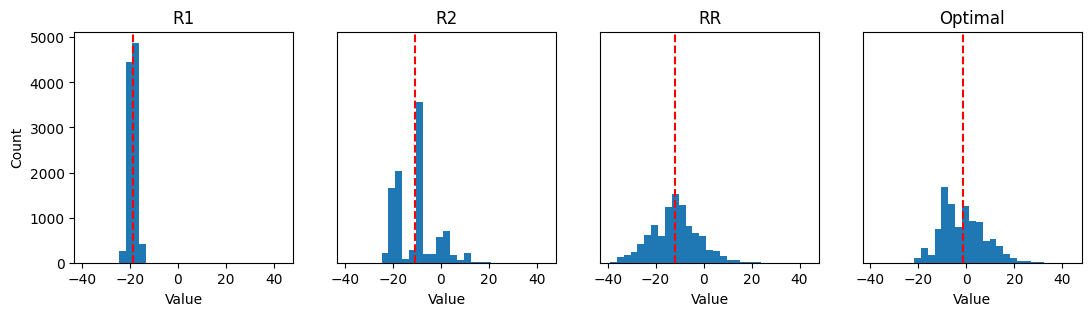

In [22]:
# Create a (wide) figure to show all histograms
fig = plt.figure(figsize=(13, 3))

# Compute (shared) bins
allVals = mcRewardsRoll1 + mcRewardsRoll2 + mcRewardsRandom + mcRewardsOptimal
bins = np.linspace(min(allVals), max(allVals), num=30)

# Plot histograms
ax1 = plt.subplot(1, 4, 1)
plt.hist(mcRewardsRoll1, bins=bins)
plt.axvline(x = np.mean(mcRewardsRoll1), color='red', linestyle='--', )
plt.title(POLICY_NAME_ROLL1)
plt.ylabel('Count')
plt.xlabel('Value')

plt.subplot(1, 4, 2, sharex=ax1, sharey=ax1)
plt.hist(mcRewardsRoll2, bins=bins)
plt.axvline(x = np.mean(mcRewardsRoll2), color='red', linestyle='--', )
plt.tick_params(left=False, labelleft=False)
plt.title(POLICY_NAME_ROLL2)
plt.xlabel('Value')

plt.subplot(1, 4, 3, sharex=ax1, sharey=ax1)
plt.hist(mcRewardsRandom, bins=bins)
plt.axvline(x = np.mean(mcRewardsRandom), color='red', linestyle='--', )
plt.tick_params(left=False, labelleft=False)
plt.title(POLICY_NAME_RANDOM)
plt.xlabel('Value')

plt.subplot(1, 4, 4, sharex=ax1, sharey=ax1)
plt.hist(mcRewardsOptimal, bins=bins)
plt.axvline(x = np.mean(mcRewardsOptimal), color='red', linestyle='--', )
plt.tick_params(left=False, labelleft=False)
plt.title(POLICY_NAME_OPTIMAL)
plt.xlabel('Value')

plt.show()

In [23]:
mcRewards = [mcRewardsRoll1, mcRewardsRoll2, mcRewardsRandom, mcRewardsOptimal]
dpValues = [valuesRoll1, valuesRoll2, valuesRandom, valuesOptimal]
labels = [POLICY_NAME_ROLL1, POLICY_NAME_ROLL2, POLICY_NAME_RANDOM, POLICY_NAME_OPTIMAL]

for mcData, values, label in zip(mcRewards, dpValues, labels):
    print('"' + label + '"')
    print('MC-estimate:', np.mean(mcData))
    print('DP-value:   ', values[0])
    print('Difference: ', np.mean(mcData) - values[0])
    print('MC-std.-dev:', np.std(mcData))
    print('')

"R1"
MC-estimate: -18.5357
DP-value:    -18.517421790193676
Difference:  -0.01827820980632211
MC-std.-dev: 1.3794656610441596

"R2"
MC-estimate: -10.6598
DP-value:    -10.736339396569166
Difference:  0.07653939656916542
MC-std.-dev: 8.36030286293505

"RR"
MC-estimate: -12.023
DP-value:    -11.87386769167468
Difference:  -0.14913230832531887
MC-std.-dev: 9.771871417492148

"Optimal"
MC-estimate: -1.5
DP-value:    -1.4533693177489182
Difference:  -0.0466306822510818
MC-std.-dev: 9.048778923147587



Some observations:

* The MC results are fairly close to the computed values
* "R1" has a very low variance
* "R2" mostly depends on the number of doubles rolled (see the distinct peaks in the histogram)
* This analysis could be expanded to verify the results for other states as well